# Boosting

### Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from joblib import dump, load

In [2]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn import tree

In [3]:
from preprocessing import reemplazarNulls,reemplazarCategoricas,reemplazarFechas,regularizar,targetBooleano,reemplazarCategoricas_OHE,reemplazarNullsNum,keepFeat_OHE

[###] Initial Preprocessings Done                           
[###] Aditional Preprocessings Done                                                   


In [4]:
from utilities import score, score2, df_feat, df_targ, train_val

### Codigo a correr

In [5]:
MAX_JOBS = 5

**Run :** Entrenar Nuevamente o Cargar Entrenado

In [6]:
runSimple = True
runValidated = True
runValidated2 = True
runReg = True
runOhe = True

**Save :** Guardar Modelo (pisa anterior)

In [7]:
saveSimple = True
saveValidated = True
saveValidated2 = True
saveReg = True
saveOhe = True
saveBest = True

In [52]:
predictions = pd.DataFrame()

### Preprocesamiento

In [9]:
targetBooleano(df_targ, inplace=True)
ohe_feat = reemplazarCategoricas_OHE(df_feat)

reemplazarNulls(df_feat , inplace=True)
reemplazarCategoricas(df_feat , inplace=True)
reemplazarFechas(df_feat , inplace=True)
df_feat_r = regularizar(df_feat)

reemplazarNullsNum(ohe_feat, inplace=True)
reemplazarFechas(ohe_feat , inplace=True)

,horas_de_sol,humedad_tarde,humedad_temprano,mm_evaporados_agua,mm_lluvia_dia,nubosidad_tarde,nubosidad_temprano,presion_atmosferica_tarde,presion_atmosferica_temprano,rafaga_viento_max_velocidad,...,missing_rafaga_viento_max_velocidad,missing_temp_max,missing_temp_min,missing_temperatura_tarde,missing_temperatura_temprano,missing_velocidad_viendo_tarde,missing_velocidad_viendo_temprano,y,m,d
id,,,,,,,,,,,,,,,,,,,,,
74816,7.629393,78.0,74.0,5.470542,68.0,4.50597,4.430203,1024.200000,1026.200000,48.0,...,False,False,False,False,False,False,False,2014,6,7
64318,7.629393,14.0,56.0,5.470542,5.8,1.00000,4.430203,998.300000,1002.500000,61.0,...,False,False,False,False,False,False,False,2014,12,7
54357,2.600000,79.0,47.0,5.470542,0.0,8.00000,7.000000,1000.500000,1005.800000,57.0,...,False,False,False,False,False,False,False,2010,7,8
1762,0.000000,92.0,96.0,3.000000,5.0,8.00000,8.000000,1015.400000,1016.800000,54.0,...,False,False,False,False,False,False,False,2015,11,4
89422,7.629393,14.0,37.0,5.470542,0.0,2.00000,4.430203,1006.400000,1011.100000,50.0,...,False,False,False,False,False,False,False,2014,12,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49272,6.500000,63.0,44.0,3.800000,0.4,6.00000,2.000000,1011.800000,1014.500000,72.0,...,False,False,False,False,False,False,False,2012,5,23
13885,2.100000,65.0,80.0,1.600000,5.2,7.00000,7.000000,1017.500000,1016.300000,48.0,...,False,False,False,False,False,False,False,2011,10,25
4586,7.629393,81.0,62.0,5.470542,0.0,4.50597,4.430203,1015.257118,1017.655555,35.0,...,False,False,False,False,False,False,False,2015,12,16


In [10]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102356 entries, 74816 to 32535
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   direccion_viento_tarde        102356 non-null  float64
 1   direccion_viento_temprano     102356 non-null  float64
 2   horas_de_sol                  102356 non-null  float64
 3   humedad_tarde                 102356 non-null  float64
 4   humedad_temprano              102356 non-null  float64
 5   llovieron_hamburguesas_hoy    102356 non-null  bool   
 6   mm_evaporados_agua            102356 non-null  float64
 7   mm_lluvia_dia                 102356 non-null  float64
 8   nubosidad_tarde               102356 non-null  float64
 9   nubosidad_temprano            102356 non-null  float64
 10  presion_atmosferica_tarde     102356 non-null  float64
 11  presion_atmosferica_temprano  102356 non-null  float64
 12  rafaga_viento_max_direccion   102356 non-

In [11]:
train_feat, val_feat, train_targ, val_targ = train_val( df_feat, df_targ, True )
train_feat_r, val_feat_r, train_targ_r, val_targ_r = train_val( df_feat_r, df_targ, True )
train_feat_ohe, val_feat_ohe, train_targ_ohe, val_targ_ohe = train_val( ohe_feat, df_targ, True )

## Entrenamiento

### Simple

In [12]:
if (runSimple):
    boost_simple = GradientBoostingClassifier(
        random_state=1,
        max_depth=3,
        min_samples_split=200,
    )
    boost_simple.fit( train_feat, train_targ )
    
    # Guardar
    if(saveSimple):
        dump(boost_simple, 'models/Ensambles/boost_simple.sk') 
else:
    # Cargar
    boost_simple = load('models/Ensambles/boost_simple.sk')

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs
AUC-ROC: 0.8669765733108965
              precision    recall  f1-score   support

       False       0.86      0.95      0.90      7946
        True       0.73      0.47      0.57      2290

    accuracy                           0.84     10236
   macro avg       0.79      0.71      0.74     10236
weighted avg       0.83      0.84      0.83     10236

CONFUSION MATRIX


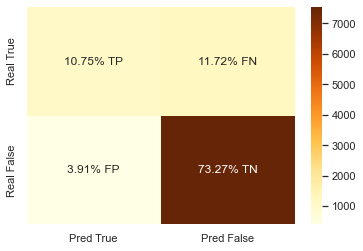

In [53]:
%time
pred = boost_simple.predict(val_feat)
prob = boost_simple.predict_proba(val_feat)
score(val_targ, pred, prob[:,1])

In [54]:
pdf = score2('Simple','Basico',val_targ, pred, prob[:,1])
predictions = predictions.append( pdf )

### Validado

In [15]:
if( runValidated ):
    boost = GradientBoostingClassifier(
        random_state=1,
    )
    
    params = {
        'max_depth': np.arange(1, 20, 1),
        'min_samples_leaf': np.arange(50, 1000, 50),
        'n_estimators': np.arange(50,500,50),
        'loss': ['deviance', 'exponential'],
        'learning_rate': [0.05,0.1,0.2],
    }
    
    boost_grid = RandomizedSearchCV(
        boost,
        params,
        scoring='roc_auc',
        n_jobs=MAX_JOBS,
        return_train_score=True,
        verbose=1
    ).fit(train_feat, train_targ)
    
    # Guardar
    if(saveValidated):
        dump(boost_grid, 'models/Ensambles/boost_grid.sk')
else:
    # Cargar
    boost_grid = load('models/Ensambles/boost_grid.sk')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [16]:
print(f"Best score: {boost_grid.best_score_}")
print(f"Best params {boost_grid.best_params_}")

Best score: 0.8904162604840289
Best params {'n_estimators': 200, 'min_samples_leaf': 200, 'max_depth': 19, 'loss': 'deviance', 'learning_rate': 0.1}


In [17]:
boost = boost_grid.best_estimator_

AUC-ROC: 0.8922015636111437
              precision    recall  f1-score   support

       False       0.88      0.94      0.91      7946
        True       0.73      0.53      0.62      2290

    accuracy                           0.85     10236
   macro avg       0.80      0.74      0.76     10236
weighted avg       0.84      0.85      0.84     10236

CONFUSION MATRIX
CPU times: user 383 ms, sys: 9.63 ms, total: 392 ms
Wall time: 361 ms


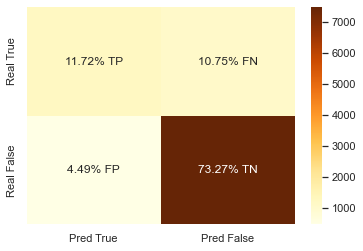

In [55]:
%%time
pred = boost.predict(val_feat)
prob = boost.predict_proba(val_feat)
score(val_targ, pred, prob[:,1])

In [56]:
pdf = score2('Val','Basico',val_targ, pred, prob[:,1])
predictions = predictions.append( pdf )

### Optimizando mas hiperparametros

In [20]:
if( runValidated2 ):
    boost2 = GradientBoostingClassifier(
        random_state=1,
    )
    
    params = {
        'max_depth': np.arange(15, 19, 1),
        'min_samples_leaf': np.arange(50, 200, 50),
        'min_samples_split': np.arange(50, 200, 50),
        'n_estimators': np.arange(200,500,100),
        'loss': ['deviance', 'exponential'],
        'learning_rate': [0.03,0.05,0.07],
        'criterion' :['friedman_mse','squared_error']
    }
    
    boost_grid2 = HalvingGridSearchCV(
        boost2,
        params,
        scoring='roc_auc',
        n_jobs=MAX_JOBS,
        return_train_score=True,
        verbose=1
    ).fit(train_feat, train_targ)
    
    # Guardar
    if(saveValidated2):
        dump(boost_grid2, 'models/Ensambles/boost2_grid.sk')
else:
    # Cargar
    boost_grid2 = load('models/Ensambles/boost2_grid.sk')

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 126
max_resources_: 92120
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1296
n_resources: 126
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
----------
iter: 1
n_candidates: 432
n_resources: 378
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
----------
iter: 2
n_candidates: 144
n_resources: 1134
Fitting 5 folds for each of 144 candidates, totalling 720 fits
----------
iter: 3
n_candidates: 48
n_resources: 3402
Fitting 5 folds for each of 48 candidates, totalling 240 fits
----------
iter: 4
n_candidates: 16
n_resources: 10206
Fitting 5 folds for each of 16 candidates, totalling 80 fits
----------
iter: 5
n_candidates: 6
n_resources: 30618
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 6
n_candidates: 2
n_resources: 91854
Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [21]:
print(f"Best score: {boost_grid2.best_score_}")
print(f"Best params {boost_grid2.best_params_}")

Best score: 0.8887505170008589
Best params {'criterion': 'squared_error', 'learning_rate': 0.03, 'loss': 'deviance', 'max_depth': 15, 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 200}


In [22]:
boost2 = boost_grid2.best_estimator_

AUC-ROC: 0.8886760194632547
              precision    recall  f1-score   support

       False       0.87      0.95      0.91      7946
        True       0.75      0.52      0.62      2290

    accuracy                           0.85     10236
   macro avg       0.81      0.74      0.76     10236
weighted avg       0.84      0.85      0.84     10236

CONFUSION MATRIX
CPU times: user 430 ms, sys: 10 ms, total: 440 ms
Wall time: 447 ms


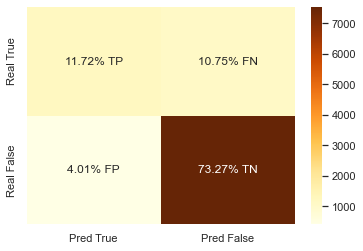

In [57]:
%%time
pred = boost2.predict(val_feat)
prob = boost2.predict_proba(val_feat)
score(val_targ, pred, prob[:,1])

In [58]:
pdf = score2('Opt','Basico',val_targ, pred, prob[:,1])
predictions = predictions.append( pdf )

### Reg

In [25]:
if( runReg ):
    boost3 = GradientBoostingClassifier(
        random_state=1,
    )
    
    params = {
        'max_depth': np.arange(1, 20, 1),
        'min_samples_leaf': np.arange(50, 1000, 50),
        'n_estimators': np.arange(50,500,50),
        'loss': ['deviance', 'exponential'],
        'learning_rate': [0.05,0.1,0.2],
    }
    
    boost_grid3 = RandomizedSearchCV(
        boost3,
        params,
        scoring='roc_auc',
        n_jobs=MAX_JOBS,
        return_train_score=True,
        verbose=1
    ).fit(train_feat_r, train_targ_r)
    
    # Guardar
    if(saveReg):
        dump(boost_grid3, 'models/Ensambles/boost_grid_r.sk')
else:
    # Cargar
    boost_grid3 = load('models/Ensambles/boost_grid_r.sk')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [26]:
print(f"Best score: {boost_grid3.best_score_}")
print(f"Best params {boost_grid3.best_params_}")

Best score: 0.8778430120012526
Best params {'n_estimators': 300, 'min_samples_leaf': 600, 'max_depth': 6, 'loss': 'deviance', 'learning_rate': 0.1}


In [27]:
boost3 = boost_grid3.best_estimator_

AUC-ROC: 0.8746432524342806
              precision    recall  f1-score   support

       False       0.87      0.95      0.91      7946
        True       0.73      0.50      0.59      2290

    accuracy                           0.85     10236
   macro avg       0.80      0.72      0.75     10236
weighted avg       0.84      0.85      0.84     10236

CONFUSION MATRIX
CPU times: user 256 ms, sys: 10.2 ms, total: 266 ms
Wall time: 234 ms


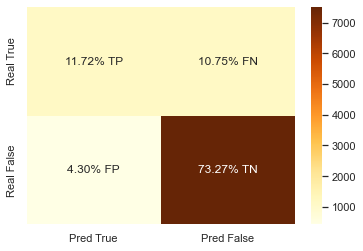

In [59]:
%%time
pred = boost3.predict(val_feat_r)
prob = boost3.predict_proba(val_feat_r)
score(val_targ_r, pred, prob[:,1])

In [60]:
pdf = score2('Reg','Regularizado',val_targ_r, pred, prob[:,1])
predictions = predictions.append( pdf )

### One Hot Encoding

In [30]:
if( runReg ):
    boost4 = GradientBoostingClassifier(
        random_state=1,
    )
    
    params = {
        'max_depth': np.arange(1, 20, 1),
        'min_samples_leaf': np.arange(50, 1000, 50),
        'n_estimators': np.arange(50,500,50),
        'loss': ['deviance', 'exponential'],
        'learning_rate': [0.05,0.1,0.2],
    }
    
    boost_grid4 = RandomizedSearchCV(
        boost4,
        params,
        scoring='roc_auc',
        n_jobs=MAX_JOBS,
        return_train_score=True,
        verbose=1
    ).fit(train_feat_ohe, train_targ_ohe)
    
    # Guardar
    if(saveReg):
        dump(boost_grid4, 'models/Ensambles/boost_grid_ohe.sk')
else:
    # Cargar
    boost_grid4 = load('models/Ensambles/boost_grid_ohe.sk')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [31]:
print(f"Best score: {boost_grid4.best_score_}")
print(f"Best params {boost_grid4.best_params_}")

Best score: 0.8972523040050518
Best params {'n_estimators': 350, 'min_samples_leaf': 200, 'max_depth': 17, 'loss': 'exponential', 'learning_rate': 0.05}


In [48]:
boost4 = boost_grid4.best_estimator_

AUC-ROC: 0.8981841403271207
              precision    recall  f1-score   support

       False       0.88      0.95      0.91      7946
        True       0.75      0.55      0.63      2290

    accuracy                           0.86     10236
   macro avg       0.81      0.75      0.77     10236
weighted avg       0.85      0.86      0.85     10236

CONFUSION MATRIX
CPU times: user 638 ms, sys: 15.8 ms, total: 654 ms
Wall time: 622 ms


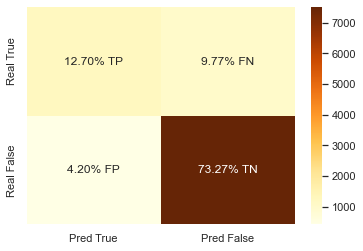

In [61]:
%%time
pred = boost4.predict(val_feat_ohe)
prob = boost4.predict_proba(val_feat_ohe)
score(val_targ_ohe, pred, prob[:,1])

In [62]:
pdf = score2('Ohe','OHE',val_targ_ohe, pred, prob[:,1])
predictions = predictions.append( pdf )

## Predictions

In [63]:
predictions

,Modelo,Preprocesamientos,Clase,AUC-ROC,Accuracy,Precision,Recall,F1 score,Support
0,Simple,Basico,AVG,0.866977,0.841051,0.830241,0.841051,0.827640,10236
1,Simple,Basico,True,NaN,NaN,0.725357,0.465939,0.567402,2290
2,Simple,Basico,False,NaN,NaN,0.860468,0.949157,0.902639,7946
0,Val,Basico,AVG,0.892202,0.851114,0.842342,0.851114,0.842462,10236
1,Val,Basico,True,NaN,NaN,0.727705,0.534498,0.616314,2290
2,Val,Basico,False,NaN,NaN,0.875380,0.942361,0.907636,7946
0,Opt,Basico,AVG,0.888676,0.853458,0.844935,0.853458,0.843689,10236
1,Opt,Basico,True,NaN,NaN,0.745342,0.524017,0.615385,2290
2,Opt,Basico,False,NaN,NaN,0.873638,0.948402,0.909486,7946
0,Reg,Regularizado,AVG,0.874643,0.846229,0.836422,0.846229,0.835526,10236


In [64]:
if(saveBest):
    dump(boost4, 'models/Ensambles/boost.sk')